
# Load process and store NR data for coprecessing frame modeling.
londonl@mit.edu 2020 / l.t.london@uva.nl 2021

## Outline

1. Load simulation with $\ell_\mathrm{max}=4$ 
2. For each $\ell$ compute FD coprecessing frame (store related angles)
3. Symmetrize the co-precessing frame data (only store $\ell=m$ models)
4. Output the symmetrized FD amplitude, phase, phase derivative, and angles

## Notes

* The q1 runs don't appears to symmetrize properly for l=m=3; should there be a q1 flag during processing? What's the origin of this issue?
* There appear to be procesing errors for some cases (e.g. discontinuities / sudden jumps in precession angles) -- 
    * Is this due to l>=2 being used to calculate the coprecessing frame?
    * Does only using lmax=2 break the higher mode amplitudes and/or phases?
* The bbh file's remnant properties for q1a04t120_dP0_T_96_552 are very likely incorrect

In [1]:
# Setup ipython environment
%load_ext autoreload
%autoreload 2
%matplotlib inline
# Setup python environment
from matplotlib.pyplot import *
from numpy import *
from positive import *
from nrutils import scsearch, gwylm
from glob import glob
import h5py
from os import path
import pickle, dill
from xcp import *

(positive)>> Applying custom matplotlib settings.
(init)>> Warm greetings from XCP.
(xcp.core)>> Catalog of calibration runs stored to "xcp.calibration_catalog"
(xcp.core)>> Metadata dictionary for Ed's catalog paper stored to "xcp.catalog_paper_metadata"


In [2]:
# Preliminaries 
# --

# Define path for file IO
package_dir = parent( xcp.__path__[0] )
data_dir = package_dir + 'data/version0/'
alert(data_dir)
mkdir(data_dir,verbose=True);

(notebook)>> /Users/book/KOALA/PhenomXCP/data/version0/
(mkdir)>> Directory at "/Users/book/KOALA/PhenomXCP/data/version0/" already exists and will be not be altered or created..


In [3]:
# Find and load data
# --

# Define simulations to load
A = scsearch(keyword='pnr-catalog',verbose=True)


(scsearch)>> Found keyword (=pnr-catalog) keyword.
(scsearch)>> Found verbose (=True) keyword.
(scsearch)>> List of keywords or string keyword found: ALL scentry objects matching will be passed. To pass ANY entries matching the keywords, input the keywords using an iterable of not of type list.
(scsearch)>> ## Found 80 possibly degenerate simulations:
(scsearch)>> [0001][pnr-catalog] q8: 1chi0.60-p-q8.00	(q8a06t60dPm2_T_96_384)
(scsearch)>> [0002][pnr-catalog] q4: 1chi0.20-p-q4.00	(q4a02t30dPm1p5_T_96_384)
(scsearch)>> [0003][pnr-catalog] q1: 2chi0.20-p-q1.00	(q1a02t90_T_96_384)
(scsearch)>> [0004][pnr-catalog] q1: 2chi0.20-p-q1.00	(q1a02t120_T_96_384)
(scsearch)>> [0005][pnr-catalog] q1: 2chi0.60-p-q1.00	(q1a06t120dPm1_T_96_552)
(scsearch)>> [0006][pnr-catalog] q8: 1chi0.60-p-q8.00	(q8a06t90dP0.8rm5_T_96_384)
(scsearch)>> [0007][pnr-catalog] q8: 1chi0.20-p-q8.00	(q8a02t60dPm4_T_96_384)
(scsearch)>> [0008][pnr-catalog] q1: 2chi0.20-p-q1.00	(q1a02t150_T_96_384)
(scsearch)>> [0009][pnr-c

In [31]:
#
catalog_path = package_dir + 'data/calibration_catalog.pickle'
alert('Saving scentry catalog list to %s'%magenta(catalog_path))
# pickle.dump( A, open( catalog_path, "wb" ) )

# Let the people know.
alert('We have found %i simulations.'%len(A))

# Define loading parameters 
lmax = 2 # NOTE --- if we want moments up to ell, then lmax=ell+1 is needed for minimal accuracy
pad = 2000
clean = True
dt = 0.5

#
kind = 'psi4'


(notebook)>> Saving scentry catalog list to /Users/book/KOALA/PhenomXCP/data/calibration_catalog.pickle
(notebook)>> We have found 80 simulations.


In [32]:
A.sort( key = lambda a: round( linalg.norm( a.m1 / a.m2 ), 1 ) + round( linalg.norm( a.S1 / a.m1**2 ), 2 ) )

(xcp.core)>> Catalog of calibration runs stored to "xcp.calibration_catalog"
(xcp.core)>> Metadata dictionary for Ed's catalog paper stored to "xcp.catalog_paper_metadata"

# -~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~ #
(notebook)>> Processing: q2_a10_a28_ph0_th150
# -~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~ #

(romline!)>> N is 2, but it must be less than or equal to 3. We have set N=3. This course is often desired in cases where N=2 is naively given.
(__calc_radiated_linear_momentum__!)>> The current objects max ell value is 2, but we recommend a value of at least 4 for accurate determination of radiated linear momentum.
(scrub)>> [(2, 2), (3, 3), (4, 4), (2, -2), (3, -3), (4, -4)]
(__rotate_frame_at_all_times__)>> TIME DOMAIN rotation specified
(__rotate_frame_at_all_times__)>> Attempting to rotate dynamics timeseries in this.dynamics
(__rotate_frame_at_all_times__)>> Note that metadata at the scentry level (i.e. this.__scentry__) hav

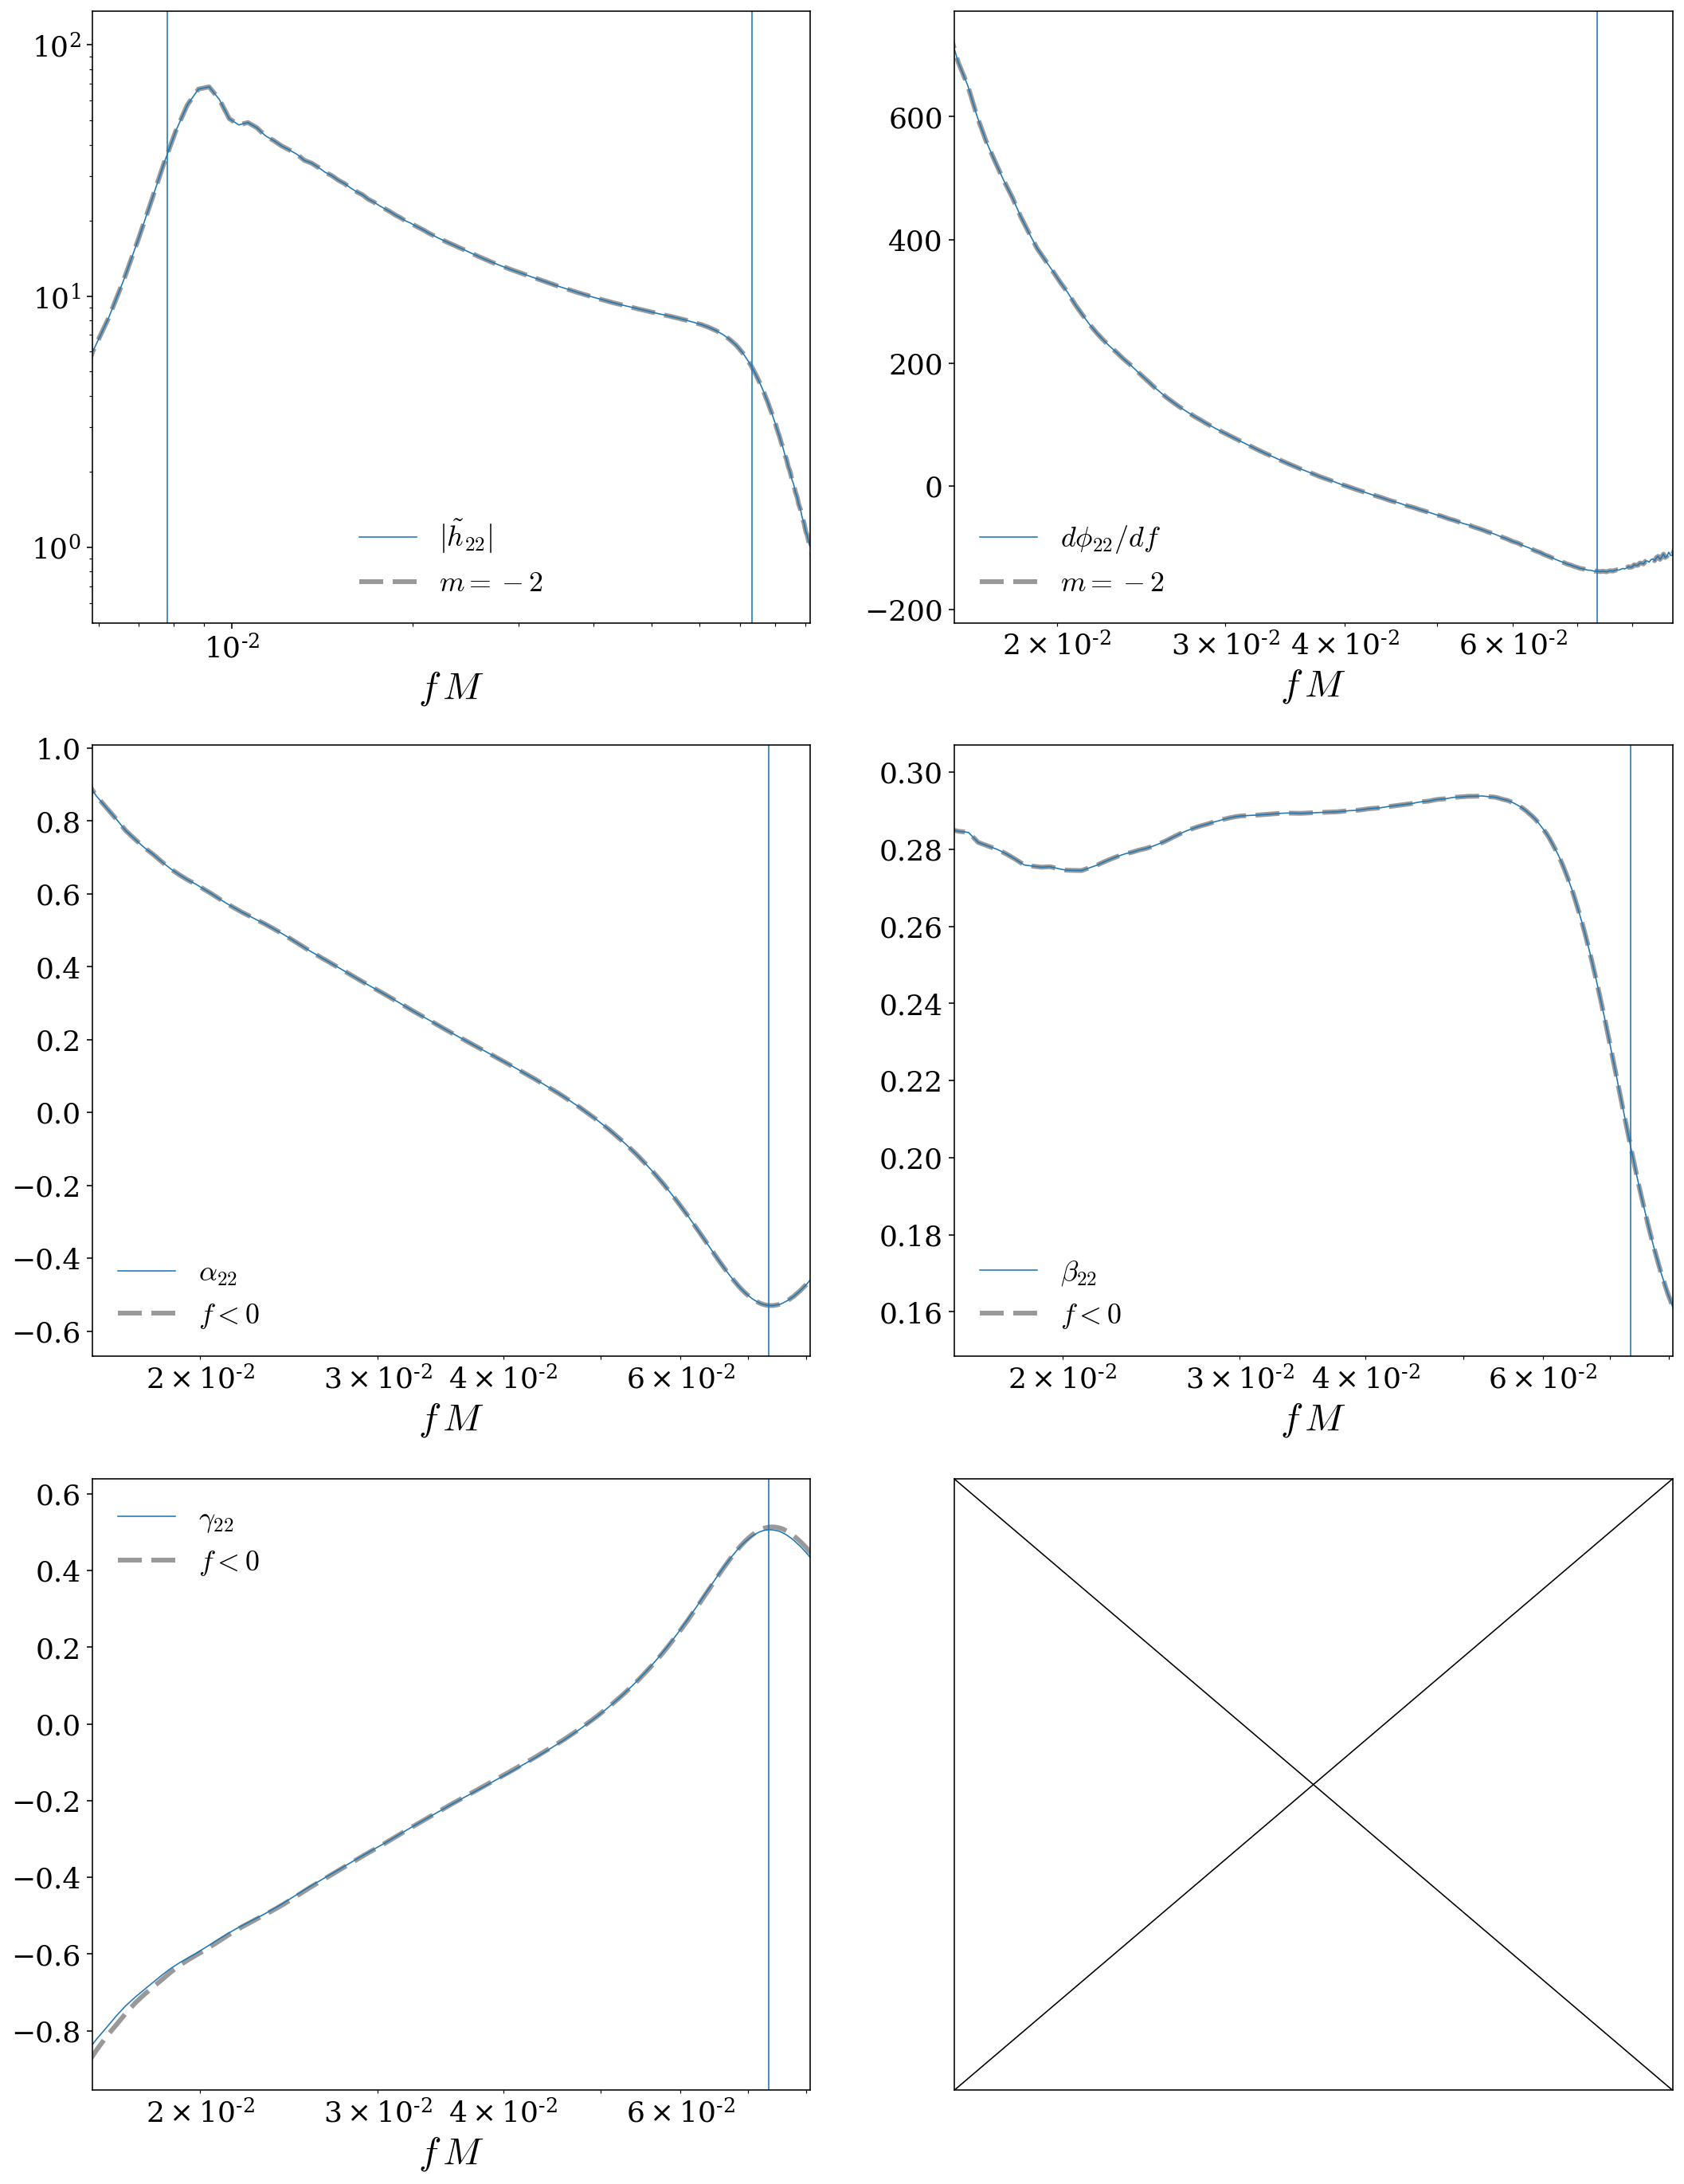

In [47]:
# Load and process simulations 
# --

# For all sims 
for a in [a for a in A if ('q2_a10_a28_ph0_th150' in a.simname)]:
    
    #
    txt_file_path = data_dir+'%s.txt'%a.simname
    # if path.exists(txt_file_path):
    #     warning('It seems that %s already exists, so we\'re moving on ...'%magenta(txt_file_path),header=True)
    #     continue
    
    #
    alert('Processing: %s'%magenta(a.simname),header=True)
    
    # Load
    y_raw = gwylm(a,lmax=lmax,dt=dt,pad=pad,clean=clean,verbose=False)
    y_raw.scrub(apply=True,lm=[(2,2),(3,3),(4,4),(2,-2),(3,-3),(4,-4)])
    
    # Manage frames using dict defined below
    frame = {}
    frame['raw'] = y_raw

    # Put in initial J frame
    frame['init-j'] = y_raw.__calc_initial_j_frame__()
    
    # Symmetrize the psi4 time domain coprecessing frame waveform, and return to the init-j frame
    frame['star-init-j'] = gwylmo_cpclean( frame['init-j'], cp_domain='td' )
    
    # NOTE that although the angles model uses the j(t) frame, 
    # we do NOT use this here as the coprecessing frame is uniquely 
    # defined and the j(t) frame only adds problematic noise
    
    alert('Computing coprecessing frames',header=True)
    # Solve optimal emission problem for l subsets
    subframe       = {}
    cp_subframe_fd = {}
    # cp_subframe_td = {}
    subangles      = {}
    # subangles_td   = {}
    for ll in range(2,lmax+1):
        
        #
        mm = ll
        
        #
        alert('Calculating coprecessing frame for l=%i subset ...'%ll)
        
        # Select only multipoles with l = ll
        subframe[ll]    = frame['star-init-j'].selectlm( [(ll,m_) for m_ in range(-ll,ll+1)] )
        
        # Solve the optimal emission problem and rotatate multipoles
        cp_subframe_fd[ll] =  subframe[ll].__calc_coprecessing_frame__( kind=kind, 
                                                                     transform_domain='fd' ).__symmetrize__(zparity=True)
        # cp_subframe_td[ll] =  subframe[ll].__calc_coprecessing_frame__( kind=kind, 
        #                                                              transform_domain='td' ).__symmetrize__(zparity=True)
        
        # Store angles for this ll
        foo = cp_subframe_fd[ll].previous_radiation_axis_info
        subangles[ll] = [ foo.radiation_axis[k] for k in ('fd_alpha','fd_beta','fd_gamma') ]
        # bar = cp_subframe_td[ll].previous_radiation_axis_info
        # subangles_td[ll] = [ foo.radiation_axis[k] for k in ('td_alpha','td_beta','td_gamma') ]
        
        # **
        alert('Saving diagnostic plot for l=m=%i ...'%ll)
        fig, ax, output_data, format_tags = collect_nr_data_plotting_helper( ll, cp_subframe_fd[ll], subangles[ll] )
        #
        png_file_path = data_dir+'%s_l%im%i.png'%(cp_subframe_fd[ll].simname,ll,mm)
        # savefig( png_file_path, pad_inches=0 )
        # alert('Diagnostic plot saved to "%s"'%yellow(png_file_path))
        # close('all')
        
        #
        txt_file_path = data_dir+'%s_l%im%i.txt'%(cp_subframe_fd[ll].simname,ll,mm)
        heaber = header = ',        '.join(format_tags)
        # alert('Saving related data to "%s"'%yellow(txt_file_path))
        # savetxt( txt_file_path, output_data, header=header )

        


([<matplotlib.axes._subplots.AxesSubplot at 0x1c355c2c50>,
 <Figure size 1266x1140 with 3 Axes>)

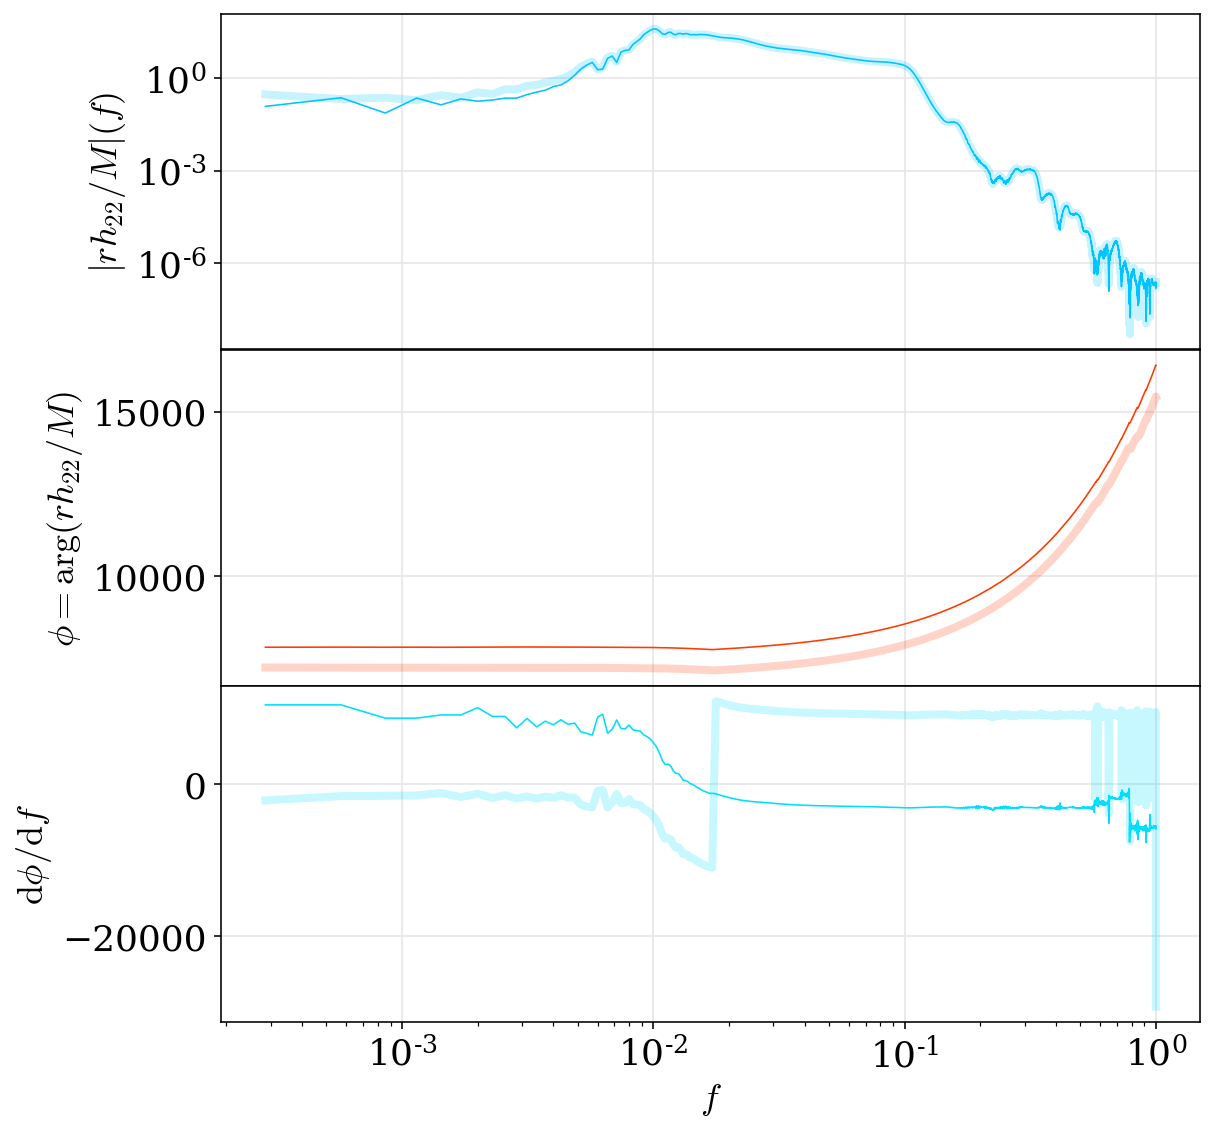

In [45]:
y_raw[2,2]['strain'].plot(ref_gwf=gwf1,domain='freq')

In [42]:
gwf1 = y_raw[2,2]['strain'].scrub()

In [43]:
gwf1.t[y_raw[2,2]['strain'].y != gwf1.y ]

array([ 204.5,  205. ,  205.5,  206. ,  206.5,  207. ,  207.5,  208. ,
        208.5,  209. ,  209.5,  210. ,  210.5,  211. ,  211.5,  212. ,
        212.5,  213. ,  213.5,  214. ,  214.5,  215. ,  215.5,  216. ,
        216.5,  217. ,  217.5,  218. ,  218.5,  219. ,  219.5,  220. ,
        220.5,  221. ,  221.5,  222. ,  222.5,  223. ,  223.5,  224. ,
        224.5,  225. ,  225.5,  226. ,  226.5,  227. ,  227.5,  228. ,
        228.5,  229. ,  229.5,  230. ,  230.5,  231. ,  231.5,  232. ,
        232.5,  233. ,  233.5,  234. ,  234.5,  235. ,  235.5,  236. ,
        236.5,  237. ,  237.5,  238. ,  238.5,  239. ,  239.5,  240. ,
        240.5,  241. ,  241.5,  242. ,  242.5,  243. ,  243.5,  244. ,
        244.5,  245. ,  245.5,  246. ,  246.5,  247. ,  247.5,  248. ,
        248.5,  249. ,  249.5,  250. ,  250.5,  251. ,  251.5,  252. ,
        252.5,  253. ,  253.5,  254. ,  254.5,  255. ,  255.5,  256. ,
        256.5,  257. ,  257.5,  258. ,  258.5,  259. ,  259.5,  260. ,
      

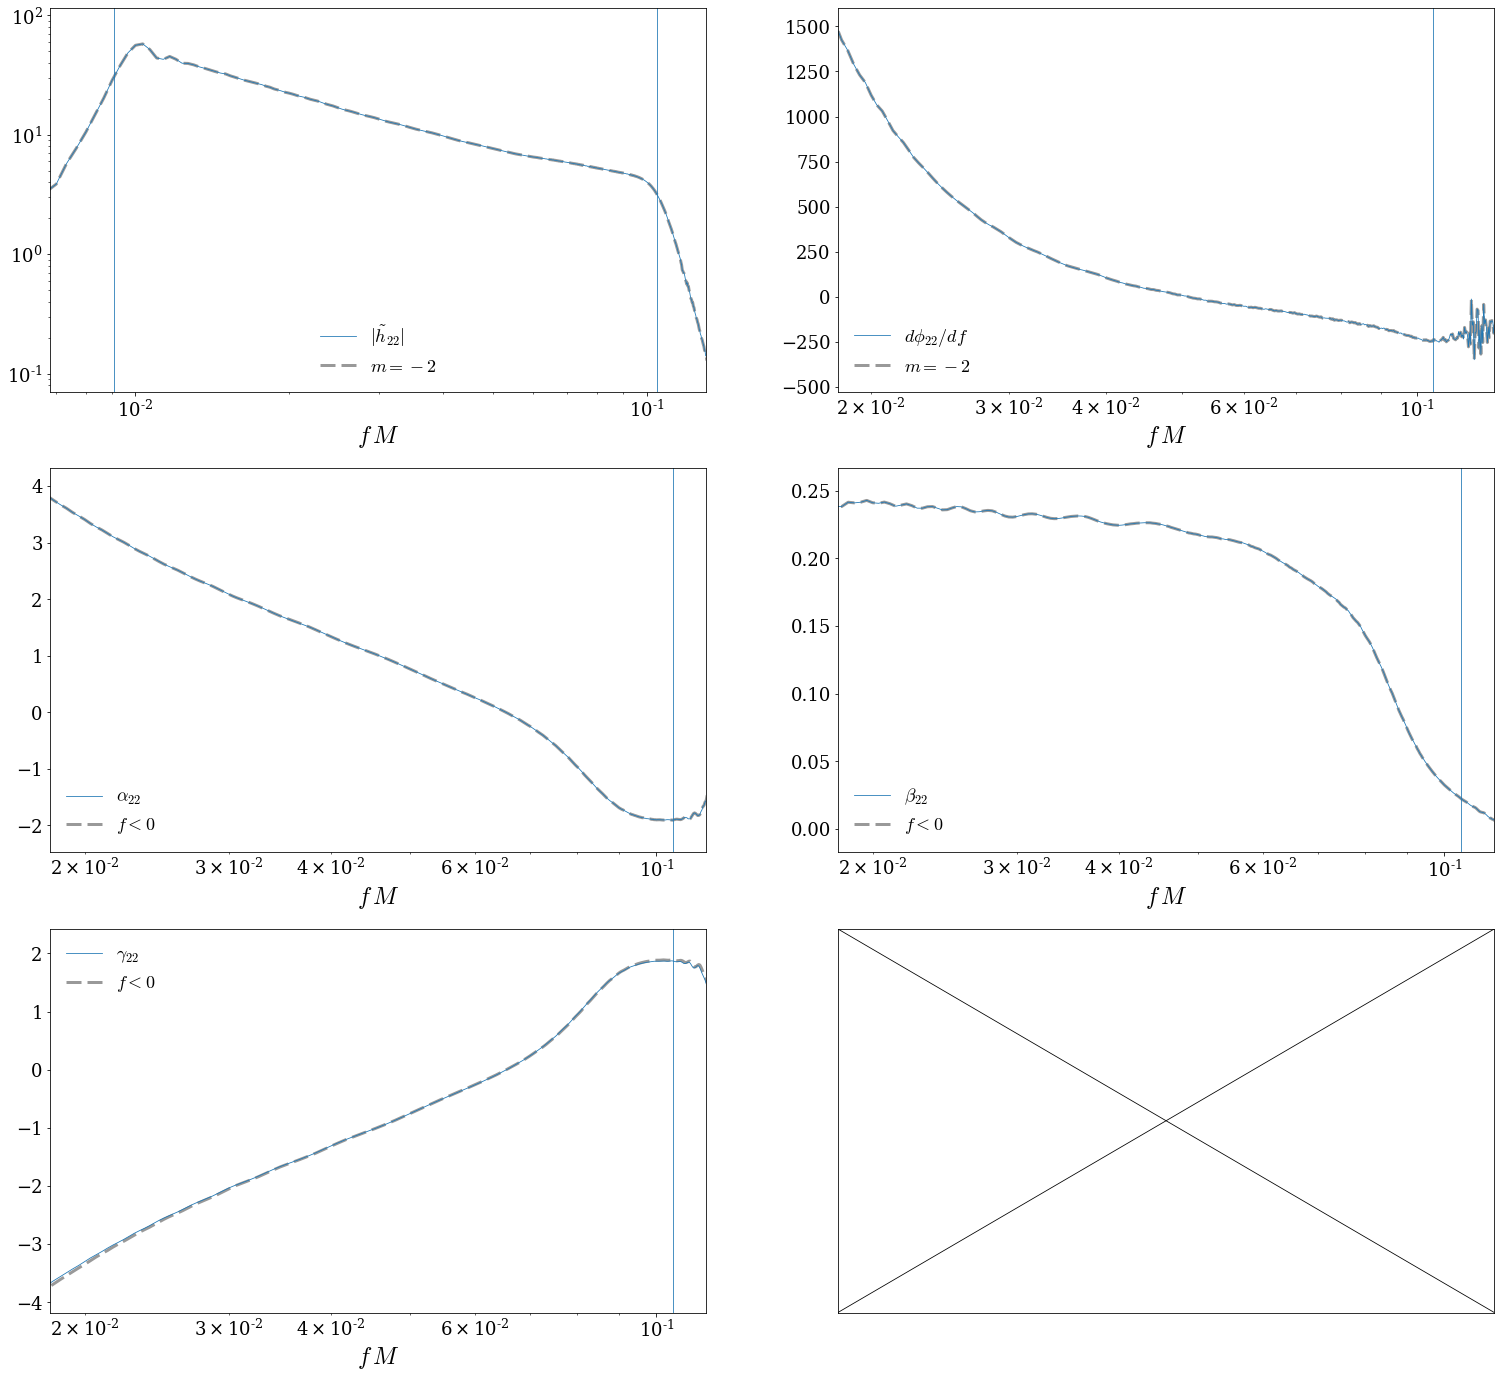

In [18]:
fig, ax, output_data, format_tags = collect_nr_data_plotting_helper( ll, cp_subframe_fd[ll], subangles[ll] )

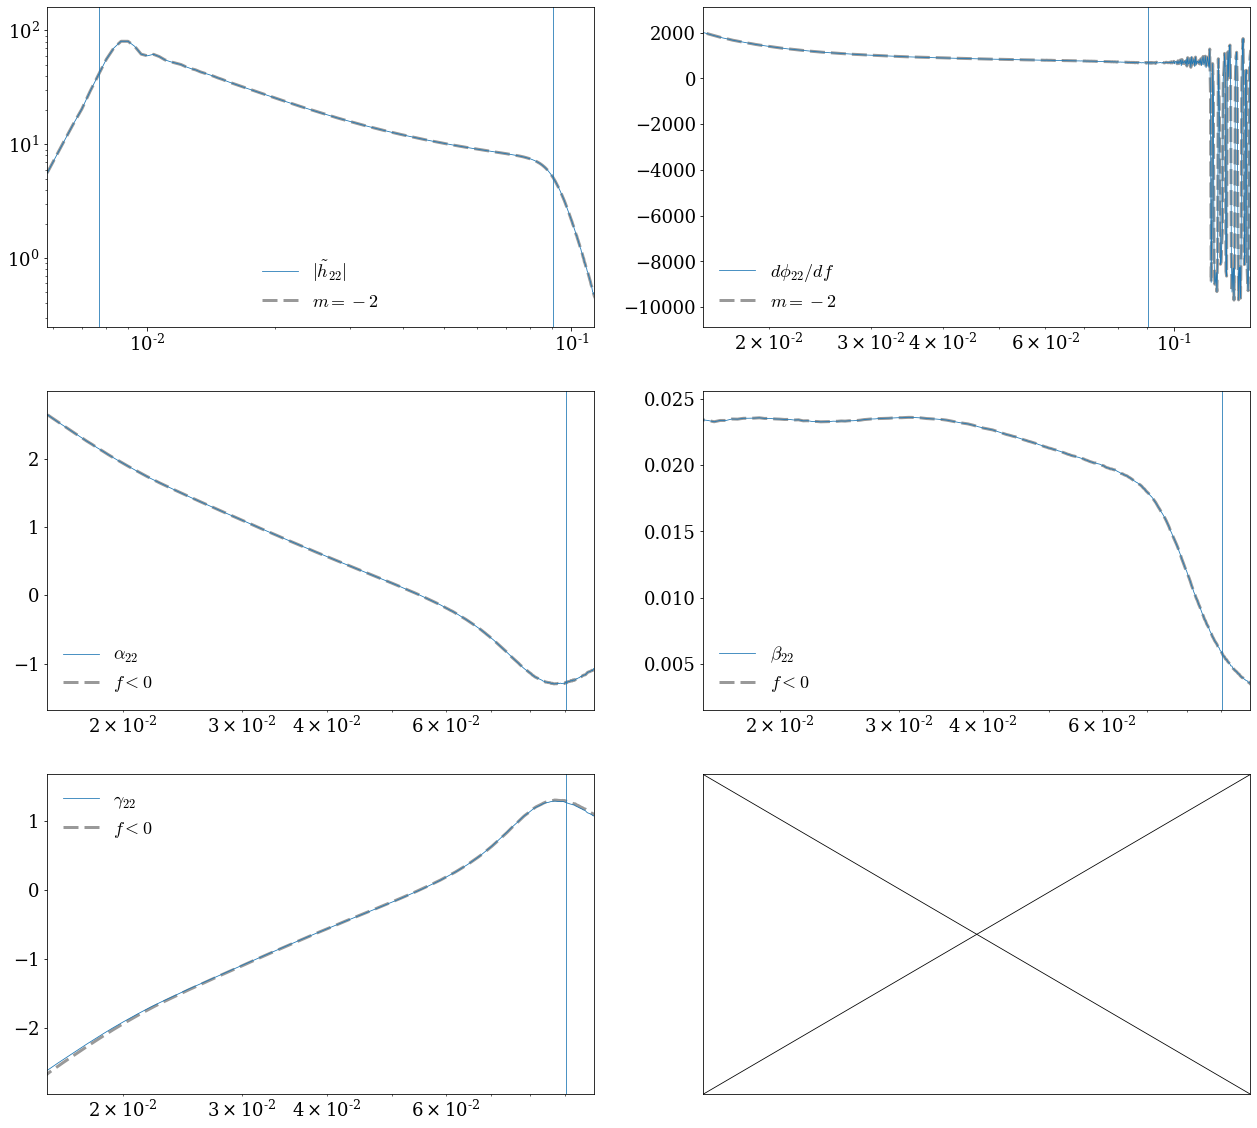

In [15]:
ll = 2

fig,ax = subplots( 3,2, figsize=5*figaspect(0.618*1.5) )
ax = ax.flatten()

#
gwfo = cp_subframe_fd[ll][ll,ll]['strain']

#
domain = subframe[ll].f
est_domain_min = (ll/2)*cp_subframe_fd[ll].wstart/(2*pi)
est_domain_max = gwfo.qnm_prograde_fring

'''
Plot FD amplitude
'''

# ------------ #
sca(ax[0])
# ------------ #

codomain1 = gwfo.fd_amp
codomain2 = abs(cp_subframe_fd[ll][ll,-ll]['strain'].fd_amp)

plot( domain, codomain1, label=r'$|\tilde{h}_{%i%i}|$'%(gwfo.l,gwfo.m) )
plot(-domain, codomain2, color = 'k', zorder=-20, label='$m=%i$'%(-ll), ls='--', lw=3, alpha=0.4 )
axvline( est_domain_max )
axvline( est_domain_min )

xscale('log')
yscale('log')

xlim( est_domain_min*0.75, est_domain_max*1.25 )
ylim( lim(limy(domain, codomain1),dilate=2.0,dilate_with_multiply=True) )
legend()


'''
Plot FD phase derivative
'''

# ------------ #
sca(ax[1])
# ------------ #

#
x0,x1 = est_domain_min*2, est_domain_max*1.5
center = lambda D,X: X - mean(X[(D>=x0) & (D<=x1)])

# 
codomain1 = center( domain, gwfo.fd_dphi )
codomain2 = center(-domain, cp_subframe_fd[ll][ll,-ll]['strain'].fd_dphi )

plot( domain, codomain1, label=r'$d\phi_{%i%i}/df$'%(gwfo.l,gwfo.m) )
plot(-domain, codomain2, color = 'k', zorder=-20, label='$m=%i$'%(-ll), ls='--', lw=3, alpha=0.4 )
axvline( est_domain_max )
axvline( est_domain_min )

xscale('log')

xlim( x0,x1 )
ylim( lim(limy(domain, codomain1),dilate=0.1) )
legend()


'''
Plot FD alpha
'''

# ------------ #
sca(ax[2])
# ------------ #

#
x0,x1 = est_domain_min*2, est_domain_max*1.1
center = lambda D,X: X - mean(X[(D>=x0) & (D<=x1)])

#
codomain1 = center(domain,-subangles[ll][0])
codomain2 = center(-domain,-subangles[ll][0])

plot( domain, codomain1, label=r'$\alpha_{%i%i}$'%(gwfo.l,gwfo.m) )
plot(-domain, codomain2, color = 'k', zorder=-20, label='$f<0$', lw=3, ls='--', alpha=0.4 )
axvline( est_domain_max )
axvline( est_domain_min )

xscale('log')

xlim( x0,x1 )
ylim( lim(limy(domain, codomain1),dilate=0.1) )
legend()


'''
Plot FD beta
'''

# ------------ #
sca(ax[3])
# ------------ #

#
x0,x1 = est_domain_min*2, est_domain_max*1.1

#
codomain1 = subangles[ll][1]
codomain2 = subangles[ll][1]

plot( domain, codomain1, label=r'$\beta_{%i%i}$'%(gwfo.l,gwfo.m) )
plot(-domain, codomain2, color = 'k', zorder=-20, label='$f<0$', lw=3, ls='--', alpha=0.4 )
axvline( est_domain_max )
axvline( est_domain_min )

xscale('log')

xlim( x0,x1 )
ylim( lim(limy(domain, codomain1),dilate=0.1) )
legend()


'''
Plot FD gamma
'''

# ------------ #
sca(ax[4])
# ------------ #

#
x0,x1 = est_domain_min*2, est_domain_max*1.1
center = lambda D,X: X - mean(X[(D>=x0) & (D<=x1)])

#
codomain1 = center(domain,-subangles[ll][2])
codomain2 = center(-domain,-subangles[ll][2])

plot( domain, codomain1, label=r'$\gamma_{%i%i}$'%(gwfo.l,gwfo.m) )
plot(-domain, codomain2, color = 'k', zorder=-20, label='$f<0$', lw=3, ls='--', alpha=0.4 )
axvline( est_domain_max )
axvline( est_domain_min )

xscale('log')

xlim( x0,x1 )
ylim( lim(limy(domain, codomain1),dilate=0.1) )
legend()

'''
Axis not used
'''

# ------------ #
sca(ax[5])
# ------------ #
plot([0,1],[0,1],color='k')
plot([0,1],[1,0],color='k')
xlim(0,1)
ylim(0,1)
xticks([])
yticks([]);